In [42]:
# Essential libraries
import os
import math
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import PIL

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.applications import ResNet50, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model

# Visualization
import plotly.graph_objs as go
from plotly.offline import iplot

# PIL
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16
import cv2
import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [43]:
MAIN_DIR = "/kaggle/input/drdataset2gb-final/train"

In [44]:
# train = []
# label = []
# for i in os.listdir(MAIN_DIR):
#   print(i)
#   data, labels = load_images(os.path.join(MAIN_DIR,i),i)
#   train.append(data)
#   label.append(labels)
#   # print(len(data))
#   # print(len(labels))
# train = np.concatenate(train, axis=0)  # Combine along the first axis
# label = np.concatenate(label, axis=0)
# print(len(train),len(label))
# # print(train)
# # print(labels)

In [45]:
# # Check the number of images in the dataset
# train = []
# label = []

# # os.listdir returns the list of files in the folder, in this case image class names
# for i in os.listdir('/kaggle/input/drdataset2gb-final/train'):
#   # print(i)
#   train_class = os.listdir(os.path.join('/kaggle/input/drdataset2gb-final/train', i))
#   for j in train_class:
#     img = os.path.join('train', i, j)
#     train.append(img)
#     label.append(i)

# #print('Number of train images : {} \n'.format(len(train)))

In [46]:
# No_images_per_class = []
# Class_name = []
# for i in os.listdir('/kaggle/input/drdataset2gb-final/train'):
#   train_class = os.listdir(os.path.join('/kaggle/input/drdataset2gb-final/train', i))
#   No_images_per_class.append(len(train_class))
#   Class_name.append(i)
#   # print('Number of images in {} = {} \n'.format(i, len(train_class)))

## TASK #3: PERFORM DATA EXPLORATION AND DATA VISUALIZATION

Has to add preprocessing

In [47]:
# Create your DataFrame
# retina_df = pd.DataFrame({'Image': train,'Labels': label})

# print(retina_df.head())











In [48]:
import os
import cv2
import pandas as pd

# Initialize lists for images and labels
train = []
label = []

# Dataset path (adjust if necessary)
dataset_path = '/kaggle/input/drdataset2gb-final/train'

# Iterate through classes and images
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        train.append(image_path)
        label.append(class_name)

# Create the DataFrame
retina_df = pd.DataFrame({'Image': train, 'Labels': label})
print("Original Dataset:\n", retina_df.head())

# Directory to save grayscale images
grayscale_dir = '/kaggle/working/bwtest'
os.makedirs(grayscale_dir, exist_ok=True)

# Convert images to grayscale and save them
grayscale_image_paths = []

for i, row in retina_df.iterrows():
    original_image_path = row['Image']
    label_folder = os.path.join(grayscale_dir, row['Labels'])  # Separate folder for each label
    os.makedirs(label_folder, exist_ok=True)

    # Load the image
    image = cv2.imread(original_image_path)
    if image is not None:
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Save grayscale image
        grayscale_image_path = os.path.join(label_folder, f"grayscale_{i}.png")
        cv2.imwrite(grayscale_image_path, gray_image)
        
        # Append path to the list
        grayscale_image_paths.append(grayscale_image_path)
    else:
        print(f"Warning: Could not load image at {original_image_path}")
        grayscale_image_paths.append(None)

# Create a new DataFrame with grayscale image paths and labels
new_retina_df = pd.DataFrame({'Image': grayscale_image_paths, 'Labels': label})
print("New Dataset with Grayscale Images:\n", new_retina_df.head())

# Save the new DataFrame as CSV (if needed)
new_retina_df.to_csv('/kaggle/working/new_retina_df.csv', index=False)


Original Dataset:
                                                Image Labels
0  /kaggle/input/drdataset2gb-final/train/Mild/43...   Mild
1  /kaggle/input/drdataset2gb-final/train/Mild/19...   Mild
2  /kaggle/input/drdataset2gb-final/train/Mild/41...   Mild
3  /kaggle/input/drdataset2gb-final/train/Mild/38...   Mild
4  /kaggle/input/drdataset2gb-final/train/Mild/27...   Mild
New Dataset with Grayscale Images:
                                          Image Labels
0  /kaggle/working/bwtest/Mild/grayscale_0.png   Mild
1  /kaggle/working/bwtest/Mild/grayscale_1.png   Mild
2  /kaggle/working/bwtest/Mild/grayscale_2.png   Mild
3  /kaggle/working/bwtest/Mild/grayscale_3.png   Mild
4  /kaggle/working/bwtest/Mild/grayscale_4.png   Mild


Plot a pie chart showing the percentage of samples per class.

## TASK #4: PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [49]:
# Shuffle the data and split it into training and testing
# retina_df = shuffle(retina_df)
# Split the DataFrame into train and temp sets (80% train, 10% Validation, 10% Test)
train_df, temp_df = train_test_split(new_retina_df, test_size=0.2, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Print the sizes of each set
print("Train set size:", len(train_df))
# print("Validation set size:", len(validation_df))
print("Test set size:", len(test_df))
# train, test = train_test_split(retina_df, test_size = 0.2)
#print(train['Image'].head())


Train set size: 28100
Test set size: 3513


Normal augmentation !!!!!!!!!!!!! need to change it.

In [50]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 3750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [51]:
# import shutil
# import os

# # Path to the working directory
# working_dir = '/kaggle/working/generated_images'

# # Delete all files and subdirectories inside the working directory
# for filename in os.listdir(working_dir):
#     file_path = os.path.join(working_dir, filename)
    
#     try:
#         if os.path.isdir(file_path):
#             shutil.rmtree(file_path)  # Delete directory and its contents
#         else:
#             os.remove(file_path)  # Delete file
#     except Exception as e:
#         print(f"Error deleting {file_path}: {e}")


In [52]:
import os
from tensorflow.keras.models import load_model
gen_path='/kaggle/input/generator-files-3'
# Load the generator models
from keras.layers import Conv2DTranspose

def custom_conv2d_transpose(*args, **kwargs):
    kwargs.pop('groups', None)  # Remove the unsupported argument
    return Conv2DTranspose(*args, **kwargs)

custom_objects = {'Conv2DTranspose': custom_conv2d_transpose}

class_generators = {
    "Mild": load_model(os.path.join(gen_path,'generator_model_mild.h5'), custom_objects=custom_objects),
    "Moderate": load_model(os.path.join(gen_path,'generator_model_moderate.h5'), custom_objects=custom_objects),
    "Proliferate_DR": load_model(os.path.join(gen_path,'generator_model_proliferate.h5'), custom_objects=custom_objects),
    "Severe": load_model(os.path.join(gen_path,'generator_model_severe.h5'), custom_objects=custom_objects)
}


In [53]:
def sample_images(generator, noise, subplots, figsize=(22,8), severity='Mild', save=False):
    generated_images = generator.predict(noise)
    
    save_dir = '/kaggle/working/generated_images/train'
    save_dir = os.path.join(save_dir, severity)
    print(save_dir)
    
    os.makedirs(save_dir, exist_ok=True)
    
    for i, image in enumerate(generated_images):
        # Reshape the image based on its expected dimensions
        image_reshaped = image.reshape((WIDTH, HEIGHT))
        
        if save == True:
            img_path = os.path.join(save_dir, f"severity_{severity}_img_{i + 1}.png")
            # Save each image individually
            plt.imsave(img_path, image_reshaped, cmap='gray')
        
        # plt.subplot(subplots[0], subplots[1], i+1)
        # plt.imshow(image_reshaped, cmap='gray')    
        # plt.axis('off')
    
    # plt.subplots_adjust(wspace=None, hspace=None)
    # plt.tight_layout()
    # plt.show()
    
    return generated_images


In [54]:
import numpy as np
NOISE_DIM = 100  
# def generate_fake_images(generator, num_images, latent_dim):
#     # Generate random noise
#     noise = np.random.normal(0, 1, (num_images, latent_dim))
#     # Generate fake images
#     fake_images = generator.predict(noise)
#     return fake_images






# Example for class1
num_fake_images = 100  # Number of fake images per class
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
fake_images_class1 = sample_images(class_generators["Mild"], noise, (10,10), (24,20), 'Mild', save=True)
fake_images_class1 = sample_images(class_generators["Moderate"], noise, (10,10), (24,20), 'Moderate', save=True)
fake_images_class1 = sample_images(class_generators["Proliferate_DR"], noise, (10,10), (24,20), 'Proliferate_DR', save=True)
fake_images_class1 = sample_images(class_generators["Severe"], noise, (10,10), (24,20), 'Severe', save=True)







# Define the number of images you want to generate for each class
# number of fake images should be less than or equal to real images, not more, gives attention on the wrong places
# num_images_per_class = {
#     "Mild": 650,
#     "Moderate": 739,
#     "Proliferate_DR": 813,
#     "Severe": 878
# }

# # Generate noise once and reuse it for different classes
# total_images = sum(num_images_per_class.values())
# noise = np.random.normal(0, 1, size=(total_images, NOISE_DIM))

# # Generate images for each class using a slice of the noise
# start_idx = 0
# for severity, num_images in num_images_per_class.items():
#     end_idx = start_idx + num_images
#     class_noise = noise[start_idx:end_idx]  # Slice the noise for this class
    
#     fake_images_class = sample_images(
#         class_generators[severity],
#         class_noise,
#         (10, 10),  # Adjust subplot size if necessary
#         (24, 20),  # Adjust figure size if necessary
    #     severity,
    #     save=True
    # )
    # print(f"{severity}: Generated {len(fake_images_class)} images.")
    # start_idx = end_idx



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
/kaggle/working/generated_images/train/Mild
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
/kaggle/working/generated_images/train/Moderate
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
/kaggle/working/generated_images/train/Proliferate_DR
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
/kaggle/working/generated_images/train/Severe


Displaying first 5 images in folder: /kaggle/working/generated_images/train/Mild


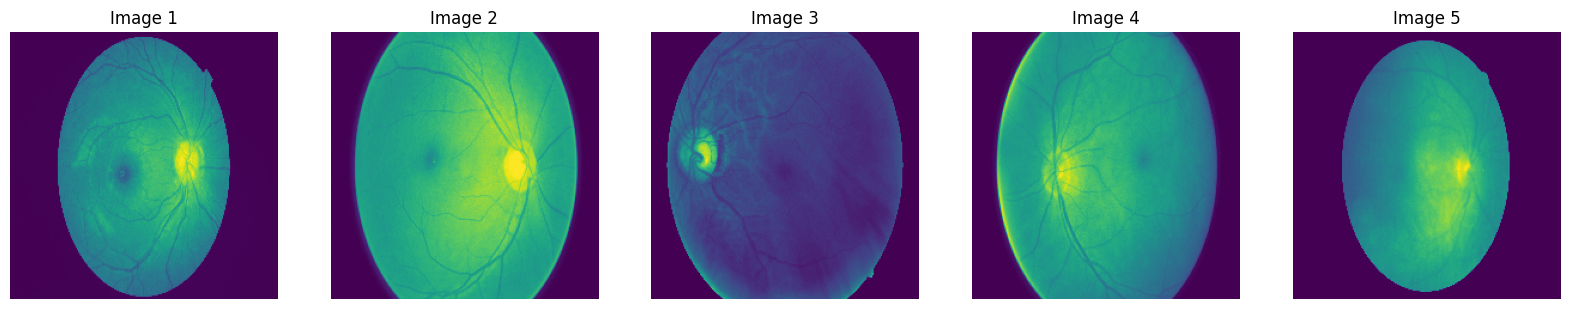

                                                   Image    Labels
27260   /kaggle/working/bwtest/No_DR/grayscale_27260.png     No_DR
29485   /kaggle/working/bwtest/No_DR/grayscale_29485.png     No_DR
26867   /kaggle/working/bwtest/No_DR/grayscale_26867.png     No_DR
25385   /kaggle/working/bwtest/No_DR/grayscale_25385.png     No_DR
21643   /kaggle/working/bwtest/No_DR/grayscale_21643.png     No_DR
...                                                  ...       ...
16850   /kaggle/working/bwtest/No_DR/grayscale_16850.png     No_DR
6265   /kaggle/working/bwtest/Moderate/grayscale_6265...  Moderate
11284   /kaggle/working/bwtest/No_DR/grayscale_11284.png     No_DR
860        /kaggle/working/bwtest/Mild/grayscale_860.png      Mild
15795   /kaggle/working/bwtest/No_DR/grayscale_15795.png     No_DR

[28100 rows x 2 columns]


In [55]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def display_first_5_images(folder_path):
    # List all subdirectories (severity folders)
    severity_folders = ['/kaggle/working/generated_images/train/Mild']
    for severity_folder in severity_folders:
        # List all image files in the folder
        image_files = sorted([f for f in os.listdir(severity_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        # Display the first 5 images
        print(f"Displaying first 5 images in folder: {severity_folder}")
        fig, axs = plt.subplots(1, 5, figsize=(20, 5))
        for i in range(min(5, len(image_files))):  # Ensure there are at least 5 images
            img_path = os.path.join(severity_folder, image_files[i])
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(f"Image {i + 1}")
        plt.show()

# Example usage: replace 'output_folder' with the path to your output directory
output_folder = "/kaggle/working/generated_images/train/"
display_first_5_images(output_folder)
print(train_df)

In [56]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import pandas as pd
import tensorflow as tf

class CustomImageDataGenerator(Sequence):
    def __init__(self, dataframe, directory, x_col, y_col, batch_size, target_size, class_mode='categorical', shuffle=True, augment=False):
        # Ensure the dataframe is a pandas DataFrame
        if isinstance(dataframe, list):
            print("Converting list to DataFrame")
            self.dataframe = pd.DataFrame(dataframe)  # Convert list to DataFrame if needed
        elif isinstance(dataframe, pd.DataFrame):
            self.dataframe = dataframe  # Directly assign if it's already a DataFrame
        else:
            raise ValueError("The dataframe is neither a list nor a pandas DataFrame.")
        
        print(f"Dataframe type: {type(self.dataframe)}")  # Debug print
        
        self.directory = directory
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))  # Initialize indexes to shuffle or cycle through data
        self.augment = augment  # If augmentation is needed

        # if self.augment:
        #     # Initialize the ImageDataGenerator for augmentation
        #     self.augmentation_generator = ImageDataGenerator(
        #         rotation_range=30,
        #         width_shift_range=0.2,
        #         height_shift_range=0.2,
        #         shear_range=0.2,
        #         zoom_range=0.2,
        #         horizontal_flip=True,
        #         fill_mode='nearest'
        #     )
    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        # Select batch indices
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Get batch data
        batch_data = self.dataframe.iloc[batch_indexes]
        
        # Prepare images
        images = []
        for img_name in batch_data[self.x_col]:
            # if isinstance(img_name, np.ndarray):  # If it's pixel data
            #     if img_name.ndim == 2:  # Grayscale
            #         img_name = np.expand_dims(img_name, axis=-1)  # Add channel dimension
            #         img_name = np.repeat(img_name, 3, axis=-1)  # Convert to RGB by repeating channels
            #     if img_name.shape[:2] != self.target_size:
            #         img_name = tf.image.resize(img_name, self.target_size).numpy()
            #     images.append(img_name)
            # else:
            #     print('here')
            img_name = str(img_name)  # Ensure it's a string
            if not img_name.endswith(('.jpg', '.png', '.jpeg')):
                raise ValueError(f"Invalid image filename: {img_name}")
            img_path = os.path.join(self.directory, img_name)
            try:
                img = load_img(img_path, target_size=self.target_size, color_mode='grayscale')  # Force RGB
                img_array = img_to_array(img)
                images.append(img_array)
            except FileNotFoundError:
                raise FileNotFoundError(f"Image file not found: {img_path}")
        
        # Convert images list to numpy array and normalize
        images = np.array(images)
        images = images / 255.0  # Normalize to [0, 1]
        # Apply augmentation if enabled
        # if self.augment:
        #     images = self.augmentation_generator.random_transform(images)  # Apply augmentation
        # Prepare labels
        labels = batch_data[self.y_col].values
        if self.class_mode == 'categorical':
            # Map string labels to integers
            unique_labels = self.dataframe[self.y_col].unique()
            label_map = {label: idx for idx, label in enumerate(unique_labels)}
            labels = np.array([label_map[label] for label in labels])
            
            # One-hot encode labels
            labels = tf.keras.utils.to_categorical(labels, num_classes=len(unique_labels))
        
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)  # Shuffle data at the end of each epoch


In [57]:
import os
import cv2
import numpy as np
# from keras.preprocessing.image import ImageDataGenerator

# Define the augmentation parameters
augmentation_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def generate_augmented_images(input_folder, output_folder, target_size=(128, 128), augmentations_per_image=1):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for class_name in os.listdir(input_folder):
        if class_name == 'No_DR':
            print(f"Skipping augmentation for class: {class_name}")
            continue
        class_path = os.path.join(input_folder, class_name)
        output_class_path = os.path.join(output_folder, class_name)

        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if image is None:
                print(f"Warning: Unable to read image {img_path}")
                continue

            # Resize image
            image = cv2.resize(image, target_size)

            # Convert grayscale to RGB for augmentation compatibility
            image = np.stack((image,) * 3, axis=-1)

            # Expand dimensions to match the generator's expected input
            image = np.expand_dims(image, axis=0)

            # Generate augmented images
            count = 0
            for batch in augmentation_generator.flow(image, batch_size=1, save_to_dir=output_class_path, save_prefix='aug', save_format='png'):
                count += 1
                if count >= augmentations_per_image:
                    break

# Paths to input and output folders
input_folder22 = '/kaggle/working/bwtest'  # Replace with your input folder path
output_folder22 = '/kaggle/working/generated_images/train'  # Replace with your output folder path

# Generate augmented images
generate_augmented_images(input_folder22, output_folder22)


Skipping augmentation for class: No_DR


In [58]:
import gc
gc.collect()

34084

Concatenating fake image with train dataframe

In [59]:
import os
import shutil

# Input and output directories
input_folder = '/kaggle/working/bwtest'
output_folder = '/kaggle/working/generated_images/train'

print(train_df)
for _, row in train_df.iterrows():
    image_path = row['Image']  # Path to the image
    label = row['Labels']  # The corresponding label
    #print(image_path)
    # Construct the corresponding output folder path
    classification_output_path = os.path.join(output_folder, label)

    # Create the classification folder if it doesn't exist
    os.makedirs(classification_output_path, exist_ok=True)
    
    # Construct the full input path to the image
    input_file_path = os.path.join(input_folder, image_path)  # Ensure image_path is relative to input_folder
    ##print("i:",input_file_path)
    # Define the output path where the image will be copied
    file_name = os.path.basename(image_path)  # Get the file name from the image path
    output_file_path = os.path.join(classification_output_path, file_name)
    #print("o:",output_file_path)
    # Ensure the image file exists before copying
    if os.path.isfile(input_file_path):
        shutil.copy(input_file_path, output_file_path)
        # Optionally print a message for debugging
        # print(f"Copied: {input_file_path} to {output_file_path}")

                                                   Image    Labels
27260   /kaggle/working/bwtest/No_DR/grayscale_27260.png     No_DR
29485   /kaggle/working/bwtest/No_DR/grayscale_29485.png     No_DR
26867   /kaggle/working/bwtest/No_DR/grayscale_26867.png     No_DR
25385   /kaggle/working/bwtest/No_DR/grayscale_25385.png     No_DR
21643   /kaggle/working/bwtest/No_DR/grayscale_21643.png     No_DR
...                                                  ...       ...
16850   /kaggle/working/bwtest/No_DR/grayscale_16850.png     No_DR
6265   /kaggle/working/bwtest/Moderate/grayscale_6265...  Moderate
11284   /kaggle/working/bwtest/No_DR/grayscale_11284.png     No_DR
860        /kaggle/working/bwtest/Mild/grayscale_860.png      Mild
15795   /kaggle/working/bwtest/No_DR/grayscale_15795.png     No_DR

[28100 rows x 2 columns]


In [60]:
print(train_df)

                                                   Image    Labels
27260   /kaggle/working/bwtest/No_DR/grayscale_27260.png     No_DR
29485   /kaggle/working/bwtest/No_DR/grayscale_29485.png     No_DR
26867   /kaggle/working/bwtest/No_DR/grayscale_26867.png     No_DR
25385   /kaggle/working/bwtest/No_DR/grayscale_25385.png     No_DR
21643   /kaggle/working/bwtest/No_DR/grayscale_21643.png     No_DR
...                                                  ...       ...
16850   /kaggle/working/bwtest/No_DR/grayscale_16850.png     No_DR
6265   /kaggle/working/bwtest/Moderate/grayscale_6265...  Moderate
11284   /kaggle/working/bwtest/No_DR/grayscale_11284.png     No_DR
860        /kaggle/working/bwtest/Mild/grayscale_860.png      Mild
15795   /kaggle/working/bwtest/No_DR/grayscale_15795.png     No_DR

[28100 rows x 2 columns]


In [61]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('/kaggle/working/generated_images/train'):
  print(i)
  train_class = os.listdir(os.path.join('/kaggle/working/generated_images/train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of fake+real images : {} \n'.format(len(train)))
train_df = pd.DataFrame({'Image': train,'Labels': label})
print(train_df)

No_DR
Proliferate_DR
Severe
Moderate
Mild
Number of fake+real images : 38095 

                                 Image Labels
0      train/No_DR/grayscale_22150.png  No_DR
1      train/No_DR/grayscale_16632.png  No_DR
2      train/No_DR/grayscale_24055.png  No_DR
3      train/No_DR/grayscale_20707.png  No_DR
4      train/No_DR/grayscale_26790.png  No_DR
...                                ...    ...
38090     train/Mild/grayscale_599.png   Mild
38091         train/Mild/aug_0_825.png   Mild
38092        train/Mild/aug_0_1359.png   Mild
38093        train/Mild/aug_0_9827.png   Mild
38094        train/Mild/aug_0_2753.png   Mild

[38095 rows x 2 columns]


In [62]:
# def preprocess_images(df, img_size=(128, 128), gamma=1.2):
#     processed_images = []
#     labels = []
#     for index, row in df.iterrows():
#         img_path = row['Image']
#         label = row['Labels']

#         # Load the image in grayscale
#         image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

#         # Step 1: Circle Crop
#         h, w = image.shape
#         center = (w // 2, h // 2)
#         radius = min(center[0], center[1])
#         mask = np.zeros((h, w), dtype=np.uint8)
#         cv2.circle(mask, center, radius, 255, thickness=-1)
#         circle_cropped = cv2.bitwise_and(image, image, mask=mask)

#         # Step 2: Adaptive Histogram Equalization
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#         equalized = clahe.apply(circle_cropped)

#         # Step 3: Gamma Correction
#         inv_gamma = 1.0 / gamma
#         table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
#         gamma_corrected = cv2.LUT(equalized, table)

#         # Step 4: Median Subtraction
#         median = cv2.medianBlur(gamma_corrected, 5)
#         median_subtracted = cv2.subtract(gamma_corrected, median)

#         # Resize image to the target size
#         resized = cv2.resize(median_subtracted, img_size, interpolation=cv2.INTER_AREA)

#         # Append processed image and label
#         processed_images.append(resized)
#         labels.append(label)

#     return processed_images, labels



import cv2
import numpy as np

def preprocess_images(df, img_size=(224, 224), gamma=1.0):
    processed_images = []
    processed_labels = []

    for idx, row in df.iterrows():
        img_path = row['Image']
        label = row['Labels']

        # Read image in grayscale
        img_path=os.path.join('/kaggle/working/generated_images',img_path)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was loaded correctly
        if image is None:
            print(f"Warning: Unable to read image at {img_path}. Skipping.")
            continue  # Skip this image if it's missing or unreadable
        
        # Step 1: Circle Crop
        h, w = image.shape
        center = (w // 2, h // 2)
        radius = min(center[0], center[1])
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, center, radius, 255, thickness=-1)
        image = cv2.bitwise_and(image, mask)
        
        # Step 2: Adaptive Histogram Equalization (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)
        
        # Step 3: Gamma Correction
        image = np.power(image / float(np.max(image)), gamma) * 255
        image = np.uint8(image)
        
        # Step 4: Median Subtraction
        median = np.median(image)
        image = image - median
        
        # Resize image to the desired size
        image = cv2.resize(image, img_size)
        # Save processed image to the directory
        # if save_dir:
        # save_path = os.path.join(save_dir, f"processed_{idx}.png")  # Adjust naming convention as needed
        cv2.imwrite(img_path, image)
        # Append the processed image and its label
        processed_images.append(image)
        processed_labels.append(label)

    return processed_images, processed_labels


In [63]:
def preprocess_images2(df, img_size=(224, 224), gamma=1.0):
    processed_images = []
    processed_labels = []

    for idx, row in df.iterrows():
        img_path = row['Image']
        label = row['Labels']

        # Read image in grayscale
        img_path=os.path.join('/kaggle/working/bwtest',img_path)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was loaded correctly
        if image is None:
            print(f"Warning: Unable to read image at {img_path}. Skipping.")
            continue  # Skip this image if it's missing or unreadable
        
        # Step 1: Circle Crop
        h, w = image.shape
        center = (w // 2, h // 2)
        radius = min(center[0], center[1])
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, center, radius, 255, thickness=-1)
        image = cv2.bitwise_and(image, mask)

        # Step 2: Adaptive Histogram Equalization (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)
        
        # Step 3: Gamma Correction
        image = np.power(image / float(np.max(image)), gamma) * 255
        image = np.uint8(image)
        
        # Step 4: Median Subtraction
        median = np.median(image)
        image = image - median
        
        # Resize image to the desired size
        image = cv2.resize(image, img_size)
        cv2.imwrite(img_path, image)
        # Append the processed image and its label
        processed_images.append(image)
        processed_labels.append(label)

    return processed_images, processed_labels
        

In [64]:
# # Preprocess the train_df
# processed_images, processed_labels = preprocess_images(train_df)

# # Add the processed images to the train_df
# # train_df['Image'] = processed_images
# # train_df['Labels'] = processed_labels
# print(train_df)

In [65]:


# # Preprocess the train_df
# processed_images, processed_labels = preprocess_images2(test_df)

# # Add the processed images to the train_df
# test_df['Image'] = processed_images
# test_df['Labels'] = processed_labels
# print(train_df)

In [66]:
No_images_per_class = []
Class_name = []
for i in os.listdir('/kaggle/working/generated_images/train'):
  train_class = os.listdir(os.path.join('/kaggle/working/generated_images/train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in No_DR = 21517 

Number of images in Proliferate_DR = 1656 

Number of images in Severe = 1844 

Number of images in Moderate = 8771 

Number of images in Mild = 4307 



In [67]:
# print(new_retina_df)

In [68]:
# Creating datagenerator for training, validation and test dataset.

train_generator = CustomImageDataGenerator(
    dataframe=train_df,
    directory='/kaggle/working/generated_images/',  # Update the directory if necessary
    x_col='Image',  # This column should contain image file names
    y_col='Labels',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    augment=True
)




validation_generator = CustomImageDataGenerator(
    dataframe=train_df,
    directory='/kaggle/working/generated_images/',  # Update the directory if necessary
    x_col='Image',
    y_col='Labels',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

test_generator = CustomImageDataGenerator(
    dataframe=test_df,
    directory='/kaggle/working/bwtest/',  # Update with the correct directory
    x_col='Image',  # This column should contain image file names
    y_col='Labels',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    augment=False
)

Dataframe type: <class 'pandas.core.frame.DataFrame'>
Dataframe type: <class 'pandas.core.frame.DataFrame'>
Dataframe type: <class 'pandas.core.frame.DataFrame'>


In [69]:
# print(train_generator.filepaths[:5])  # Print first 5 filepaths from train_generator
# print(validation_generator.filepaths[:5])  # Print first 5 filepaths from validation_generator
print(train_df)

                                 Image Labels
0      train/No_DR/grayscale_22150.png  No_DR
1      train/No_DR/grayscale_16632.png  No_DR
2      train/No_DR/grayscale_24055.png  No_DR
3      train/No_DR/grayscale_20707.png  No_DR
4      train/No_DR/grayscale_26790.png  No_DR
...                                ...    ...
38090     train/Mild/grayscale_599.png   Mild
38091         train/Mild/aug_0_825.png   Mild
38092        train/Mild/aug_0_1359.png   Mild
38093        train/Mild/aug_0_9827.png   Mild
38094        train/Mild/aug_0_2753.png   Mild

[38095 rows x 2 columns]


Experiment with other image augmentation strategies to the training data. We can pick any one augmentation strategy.

HINT: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

## TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS (CNN) AND RESIDUAL BLOCKS

![Description](./images/cnn.png)

### RESNET (RESIDUAL NETWORK)
- As CNNs grow deeper, vanishing gradient tend to occur which negatively impact network performance.
- Vanishing gradient problem occurs when the gradient is back-propagated to earlier layers
which results in a very small gradient.
- Residual Neural Network includes "skip connection" feature which enables training of 152 layers without vanishing gradient issues.
- Resnet works by adding "identity mappings" on top of the CNN.
ImageNet contains 11 million images and 11,000 categories. ImageNet is used to train Res- Net deep network.


![Example Image](https://upload.wikimedia.org/wikipedia/commons/5/59/Resnet.png)

![Description](./images/resmodel.png)

![Description](./images/conv.png)

## TASK #6: BUILD RES-BLOCK BASED DEEP LEARNING MODEL

In [70]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [71]:

input_shape = (224,224,1)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

# Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

# model.summary()

# TASK #7: COMPILE AND TRAIN DEEP LEARNING MODEL

In [72]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [73]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.keras", verbose=1, save_best_only=True)

Epoch 1/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5340 - loss: 2.6129
Epoch 1: val_loss improved from inf to 3.07384, saving model to weights.keras
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 167s 120ms/step - accuracy: 0.5340 - loss: 2.6120 - val_accuracy: 0.1835 - val_loss: 3.0738
Epoch 2/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6362 - loss: 1.1317
Epoch 2: val_loss improved from 3.07384 to 1.07478, saving model to weights.keras
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 127s 106ms/step - accuracy: 0.6362 - loss: 1.1317 - val_accuracy: 0.6456 - val_loss: 1.0748
Epoch 3/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6643 - loss: 1.0117
Epoch 3: val_loss improved from 1.07478 to 0.99890, saving model to weights.keras
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 126s 105ms/step - accuracy: 0.6643 - loss: 1.0117 - val_accuracy: 0.6721 - val_loss: 0.9989
Epoch 4/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6772 - loss: 0.9659
Epoch 4: val_loss improved from 0

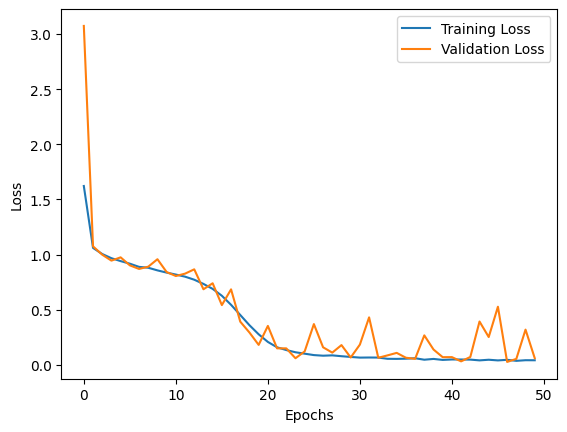

In [74]:
# Use train_generator to train the model
history = model.fit(train_generator, epochs = 50, validation_data= validation_generator, callbacks=[checkpointer , earlystopping])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
model.fit(test_generator, epochs = 13, validation_data= validation_generator, callbacks=[checkpointer , earlystopping])

Epoch 1/13
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6540 - loss: 2.2882
Epoch 1: val_loss did not improve from 0.02644
110/110 ━━━━━━━━━━━━━━━━━━━━ 56s 513ms/step - accuracy: 0.6542 - loss: 2.2812 - val_accuracy: 0.5601 - val_loss: 1.4615
Epoch 2/13
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7317 - loss: 0.7779
Epoch 2: val_loss did not improve from 0.02644
110/110 ━━━━━━━━━━━━━━━━━━━━ 42s 380ms/step - accuracy: 0.7318 - loss: 0.7778 - val_accuracy: 0.6058 - val_loss: 1.2985
Epoch 3/13
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8024 - loss: 0.5695
Epoch 3: val_loss did not improve from 0.02644
110/110 ━━━━━━━━━━━━━━━━━━━━ 42s 381ms/step - accuracy: 0.8024 - loss: 0.5694 - val_accuracy: 0.6012 - val_loss: 1.3421
Epoch 4/13
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9007 - loss: 0.3262
Epoch 4: val_loss did not improve from 0.02644
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 405ms/step - accuracy: 0.9006 - loss: 0.3263 - val_accuracy: 0.6086 - 

In [75]:
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# # Get predictions and true labels
# y_pred = model.predict(test_generator, steps=len(test_generator))
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true =test_generator.dataframe[test_generator.y_col].values

# # Print classification report
# print(classification_report(y_true, y_pred_classes))

# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred_classes)
# print("Confusion Matrix:")
# print(cm)

In [76]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train_loss','val_loss'], loc = 'upper right')
# plt.show()

## TASK #8: ASSESS THE PERFORMANCE OF THE TRAINED MODEL

![Description](./images/conmat.png)

In [77]:
# model.load_weights("weights.keras")
# print(os.listdir())

In [84]:
# Evaluate the performance of the model
# evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)
# Test the model using the test generator
steps = len(test_generator)  # or test_generator.samples // test_generator.batch_size
print(steps)
evaluate = model.evaluate(test_generator, steps=steps, verbose=1)
print(evaluate)
print('Loss Test : {}'.format(evaluate[0]))
print('Accuracy Test : {}'.format(evaluate[1]))
# print('Precision Test : {}'.format(evaluate[2]))
# print('Recall Test : {}'.format(evaluate[3]))

110
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9905 - loss: 0.0334
[0.032656822353601456, 0.9906063079833984]
Loss Test : 0.032656822353601456
Accuracy Test : 0.9906063079833984


In [85]:
# Predict on validation/test data
y_pred_probs = model.predict(test_generator)  # Predicted probabilities
# print(y_pred.shape)
y_pred = np.argmax(y_pred_probs, axis=1)     # Predicted class indices
# print(y_pred.shape)
# True labels
y_true = test_generator.dataframe[test_generator.y_col].values
unique_labels = test_generator.dataframe[test_generator.y_col].unique()
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_true = np.array([label_map[label] for label in y_true])  # Map string labels to integer indices
# print(y_true.shape)

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


In [86]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=unique_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Classification Report:
                precision    recall  f1-score   support

         No_DR       0.99      1.00      0.99      2562
      Moderate       1.00      0.97      0.98       526
          Mild       1.00      0.97      0.98       263
Proliferate_DR       1.00      0.96      0.98        75
        Severe       1.00      0.95      0.98        87

      accuracy                           0.99      3513
     macro avg       1.00      0.97      0.98      3513
  weighted avg       0.99      0.99      0.99      3513

Confusion Matrix:
[[2561    1    0    0    0]
 [  17  509    0    0    0]
 [   8    0  255    0    0]
 [   3    0    0   72    0]
 [   4    0    0    0   83]]


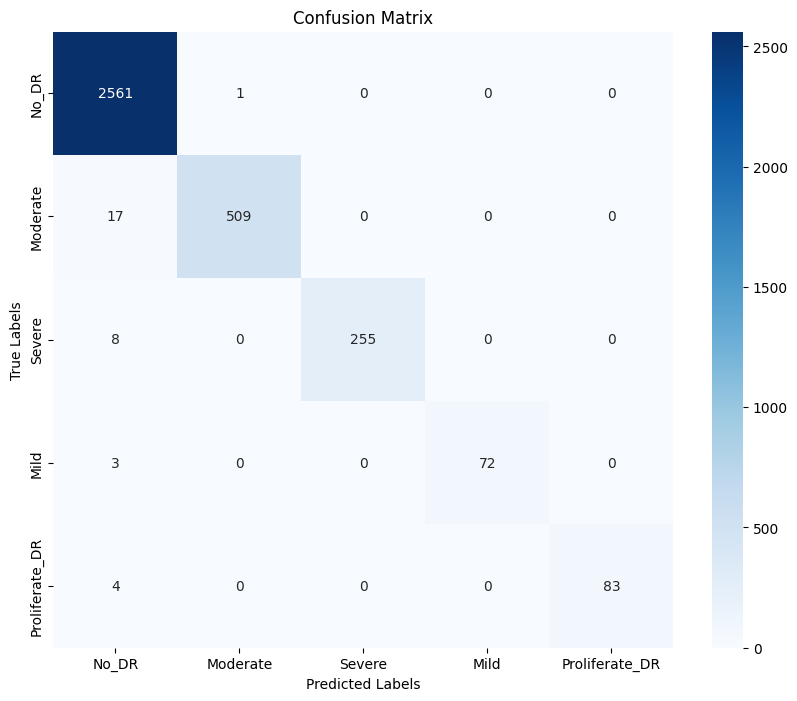

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
class_labels=['No_DR','Moderate','Severe','Mild','Proliferate_DR']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Class Distribution: {'Mild': 2443, 'Proliferate_DR': 708, 'Moderate': 5292, 'No_DR': 25810, 'Severe': 873}


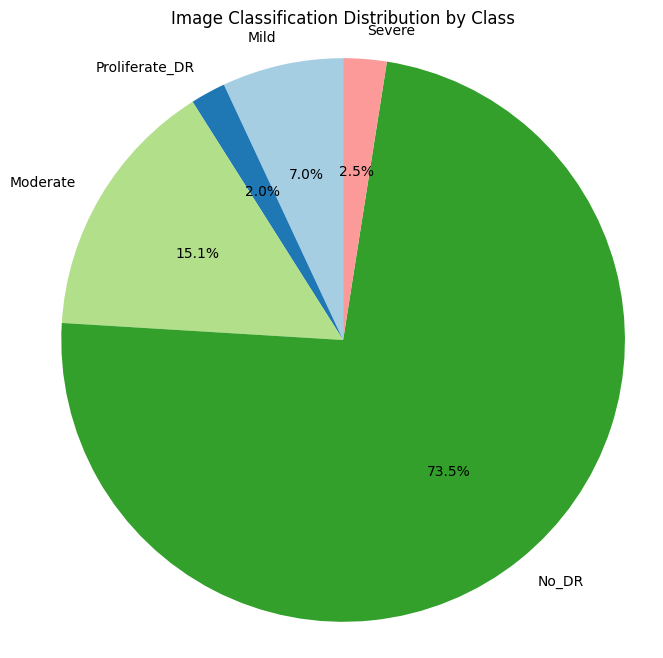

In [82]:
import os
import matplotlib.pyplot as plt

# Dataset path (adjust if necessary)
dataset_path = '/kaggle/input/drdataset2gb-final/train'

# Initialize class counters
class_counts = {}

# Iterate through classes and images
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory
        image_count = len(os.listdir(class_path))
        class_counts[class_name] = image_count

# Print class distribution for verification
print("Class Distribution:", class_counts)

# Generate pie chart
labels = list(class_counts.keys())
sizes = list(class_counts.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Image Classification Distribution by Class")
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()
